### **INTRODUCTION**

This project aims to predict housing prices using Spark ML on the California Housing Prices dataset. A comprehensive analysis of the dataset was conducted to select specific attributes and prepare the data for ML algorithms. Various regression models were built using PySpark and their performance was rigorously evaluated. The results obtained in the project, data analysis process and model development stages are presented as follows.

Data set used: https://www.kaggle.com/datasets/camnugent/california-housing-prices


In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=5dd830d7ed99f0a3ce8f84ce9c08169e87789b8e40d9ac65c6d87710659149dd
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [2]:
from pyspark.sql import SparkSession  # Used to create a Spark session.
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder  # Used for vectorizing numerical features, numerical data transformation, and binary vectorization.
from pyspark.ml.regression import LinearRegression, DecisionTreeRegressor, RandomForestRegressor, GBTRegressor  # Used for regression modeling.
from pyspark.ml.evaluation import RegressionEvaluator  # Used for model evaluation.
from pyspark.sql.functions import mean  # Used for handling missing values in the data.
import pandas as pd
import numpy as np

In [3]:
from google.colab import drive  # Necessary for accessing CSV files stored in Google Drive.
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
file_path = '/content/drive/MyDrive/Colab Notebooks/housing.csv'  # Accessing the CSV file.

df = pd.read_csv(file_path)  # Verify the correctness of the file with a DataFrame.
print(df)



       longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0        -122.23     37.88                41.0        880.0           129.0   
1        -122.22     37.86                21.0       7099.0          1106.0   
2        -122.24     37.85                52.0       1467.0           190.0   
3        -122.25     37.85                52.0       1274.0           235.0   
4        -122.25     37.85                52.0       1627.0           280.0   
...          ...       ...                 ...          ...             ...   
20635    -121.09     39.48                25.0       1665.0           374.0   
20636    -121.21     39.49                18.0        697.0           150.0   
20637    -121.22     39.43                17.0       2254.0           485.0   
20638    -121.32     39.43                18.0       1860.0           409.0   
20639    -121.24     39.37                16.0       2785.0           616.0   

       population  households  median_income  media

In [5]:
# SparkSession is created and the application starts running.
spark = SparkSession.builder \
    .appName("California_Housing_Prices") \
    .getOrCreate()

spark  # Connection check.

In [6]:
# The dataset is loaded.
data = spark.read.format("csv").load("/content/drive/MyDrive/Colab Notebooks/housing.csv", header=True, inferSchema=True)

In [7]:
# Display the first 10 observations of the dataset along with their attributes and descriptive statistics.
print("First 10 observations of the dataset:")
data.show(10)

First 10 observations of the dataset:
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|  -122.23|   37.88|              41.0|      880.0|         129.0|     322.0|     126.0|       8.3252|          452600.0|       NEAR BAY|
|  -122.22|   37.86|              21.0|     7099.0|        1106.0|    2401.0|    1138.0|       8.3014|          358500.0|       NEAR BAY|
|  -122.24|   37.85|              52.0|     1467.0|         190.0|     496.0|     177.0|       7.2574|          352100.0|       NEAR BAY|
|  -122.25|   37.85|              52.0|     1274.0|         235.0|     558.0|     219.0|       5.6431|          341300.0|       NEAR B

In [8]:
# Investigate the data types of attributes.
print("Attributes and their data types in the dataset:")
data.printSchema()

Attributes and their data types in the dataset:
root
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- housing_median_age: double (nullable = true)
 |-- total_rooms: double (nullable = true)
 |-- total_bedrooms: double (nullable = true)
 |-- population: double (nullable = true)
 |-- households: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- median_house_value: double (nullable = true)
 |-- ocean_proximity: string (nullable = true)



In [9]:
# Examine descriptive statistics.
print("Descriptive statistics of the dataset:")
data.describe().show()

Descriptive statistics of the dataset:
+-------+-------------------+-----------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+---------------+
|summary|          longitude|         latitude|housing_median_age|       total_rooms|    total_bedrooms|        population|       households|     median_income|median_house_value|ocean_proximity|
+-------+-------------------+-----------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+---------------+
|  count|              20640|            20640|             20640|             20640|             20433|             20640|            20640|             20640|             20640|          20640|
|   mean|-119.56970445736148| 35.6318614341087|28.639486434108527|2635.7630813953488| 537.8705525375618|1425.4767441860465|499.5396802325581|3.8706710029070246|206855.8169089147

In [10]:
indexer = StringIndexer(inputCol="ocean_proximity", outputCol="ocean_proximity_index")  # Since ocean_proximity is not a numerical column, transformation is required. StringIndexer is used for this purpose.
data_indexed = indexer.fit(data).transform(data)  # Iterates over the dataset to assign index numbers and provides matching.

# The new ocean_proximity column is converted to a binary vector using one-hot encoding.
encoder = OneHotEncoder(inputCol="ocean_proximity_index", outputCol="ocean_proximity_encoded")  # Define the columns to be transformed and the transformed column names.
encoder_model = encoder.fit(data_indexed)  # Create a model and train it to convert categorical data to binary vectors.
data_encoded = encoder_model.transform(data_indexed)  # Convert the ocean_proximity_index column to a binary vector using the model.

In [11]:
numerical_columns = ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms',
                     'population', 'households', 'median_income']

# Since there are missing values in the dataset, the mean values of the columns are used to replace missing data.
for column in numerical_columns:  # Iterate through all columns.
    mean_value = data_encoded.select(mean(column)).collect()[0][0]  # Calculate the mean of the column.
    data_encoded = data_encoded.na.fill(mean_value, [column])  # Fill rows with missing values with the mean value.


In [12]:
assembler = VectorAssembler(inputCols=numerical_columns + ['ocean_proximity_encoded'], outputCol="features")  # All columns are specified as input.

# Vector transformation
data_prepared = assembler.transform(data_encoded)  # Create a new DataFrame (data_prepared) containing a feature vector for each observation.

# Split the data into training and testing sets.
train_data, test_data = data_prepared.randomSplit([0.8, 0.2], seed=42)  # 80% training - 20% testing

In [13]:
models = {
    "Linear Regression": LinearRegression(featuresCol="features", labelCol="median_house_value"),
    "Decision Tree Regressor": DecisionTreeRegressor(featuresCol="features", labelCol="median_house_value"),
    "Random Forest Regressor": RandomForestRegressor(featuresCol="features", labelCol="median_house_value"),
    "Gradient Boosted Tree Regressor": GBTRegressor(featuresCol="features", labelCol="median_house_value")
}

model_predictions = {}  # Create a dictionary to store the predictions and actual values of the models for visualization.

for model_name, model in models.items():  # Iterate through each model.
    print("Training", model_name, "...")
    model_fit = model.fit(train_data)  # Train the model with the training data.
    predictions = model_fit.transform(test_data)  # Make predictions on the test data using the trained model.
    model_predictions[model_name] = predictions.select("prediction", "median_house_value").toPandas()  # Save predictions and actual values.

    # RMSE and R^2 are used for performance measurement.
    evaluator_rmse = RegressionEvaluator(labelCol="median_house_value", predictionCol="prediction", metricName="rmse")  # Create a RegressionEvaluator object for RMSE.
    evaluator_r2 = RegressionEvaluator(labelCol="median_house_value", predictionCol="prediction", metricName="r2")  # Create a RegressionEvaluator object for R^2.
    rmse = evaluator_rmse.evaluate(predictions)  # RMSE value.
    r2 = evaluator_r2.evaluate(predictions)  # R^2 value.
    print(model_name, "Root Mean Squared Error (RMSE):", rmse)
    print(model_name, "R-squared (R^2):", r2)
    print("Predictions on the test data:")
    predictions.select("prediction", "median_house_value", "features").show()

Training Linear Regression ...
Linear Regression Root Mean Squared Error (RMSE): 70781.23017920901
Linear Regression R-squared (R^2): 0.6378987876472288
Predictions on the test data:
+------------------+------------------+--------------------+
|        prediction|median_house_value|            features|
+------------------+------------------+--------------------+
|150428.91124392953|          103600.0|[-124.3,41.84,17....|
|217515.79790595733|          106700.0|[-124.23,40.54,52...|
|125091.61653210502|           73200.0|[-124.23,41.75,11...|
|194918.60580605734|           90100.0|[-124.19,40.73,21...|
| 152202.4478811007|           67000.0|[-124.18,40.78,34...|
|185981.03237971012|           86400.0|[-124.17,40.62,32...|
|163796.49716672394|           70500.0|[-124.17,40.79,43...|
| 179884.3602691181|           85100.0|[-124.16,40.6,39....|
|181487.00247835973|           80500.0|[-124.16,40.8,52....|
| 170206.7916295142|           96000.0|[-124.16,40.95,20...|
| 136906.5990232681|    

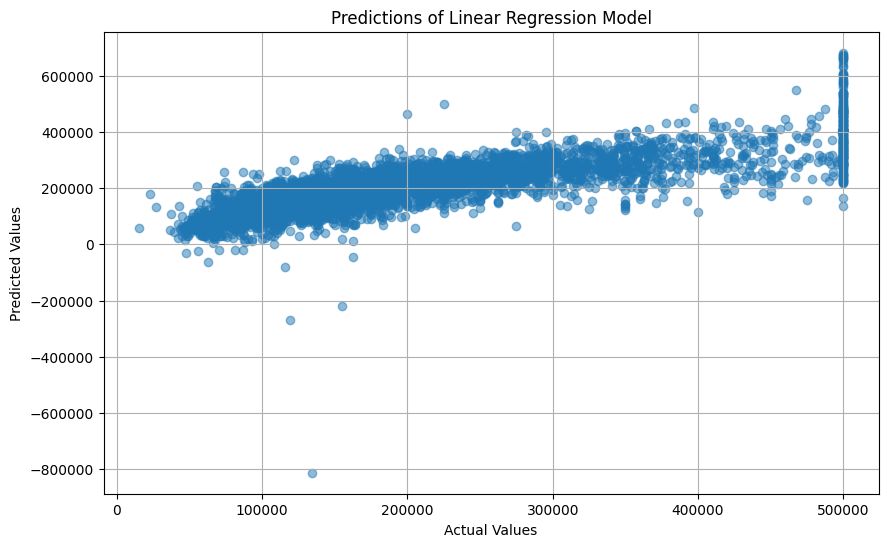

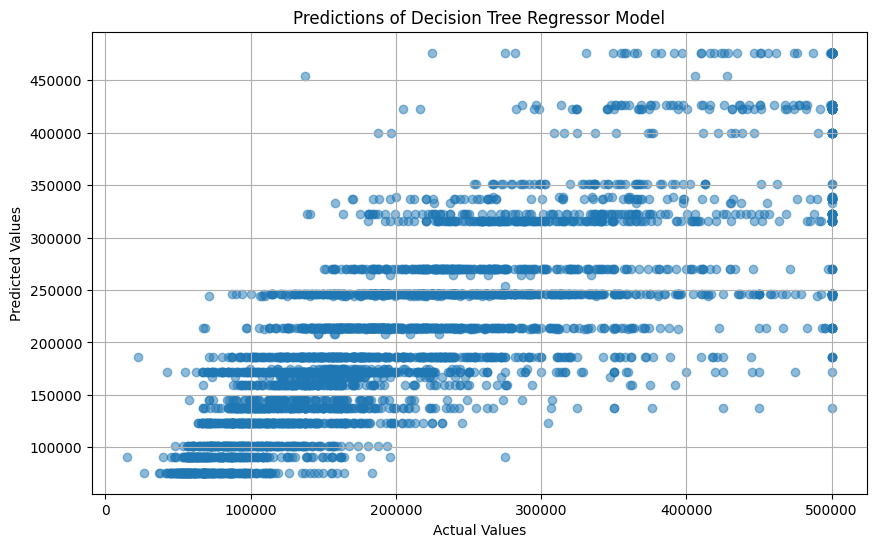

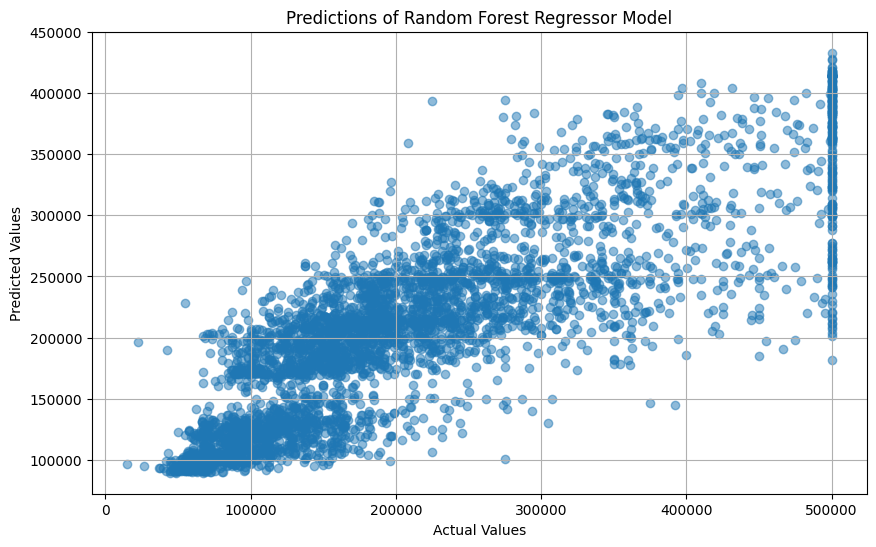

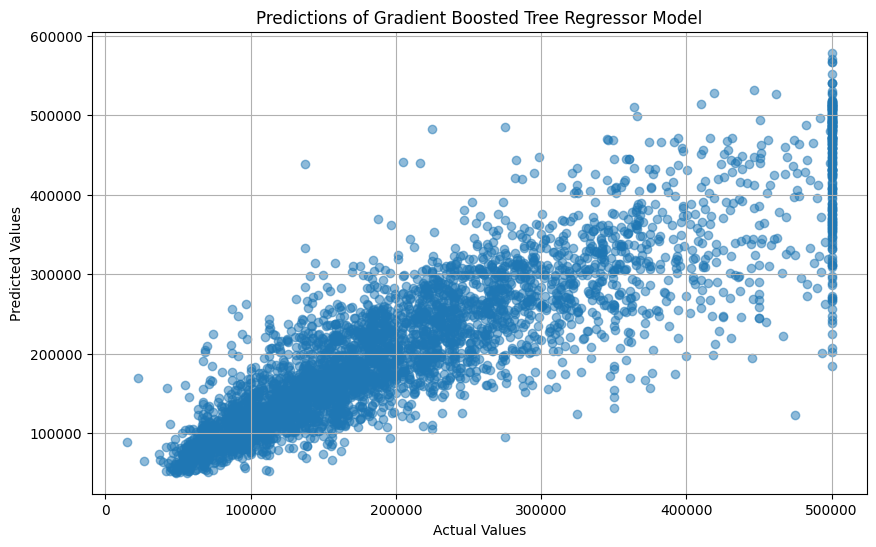

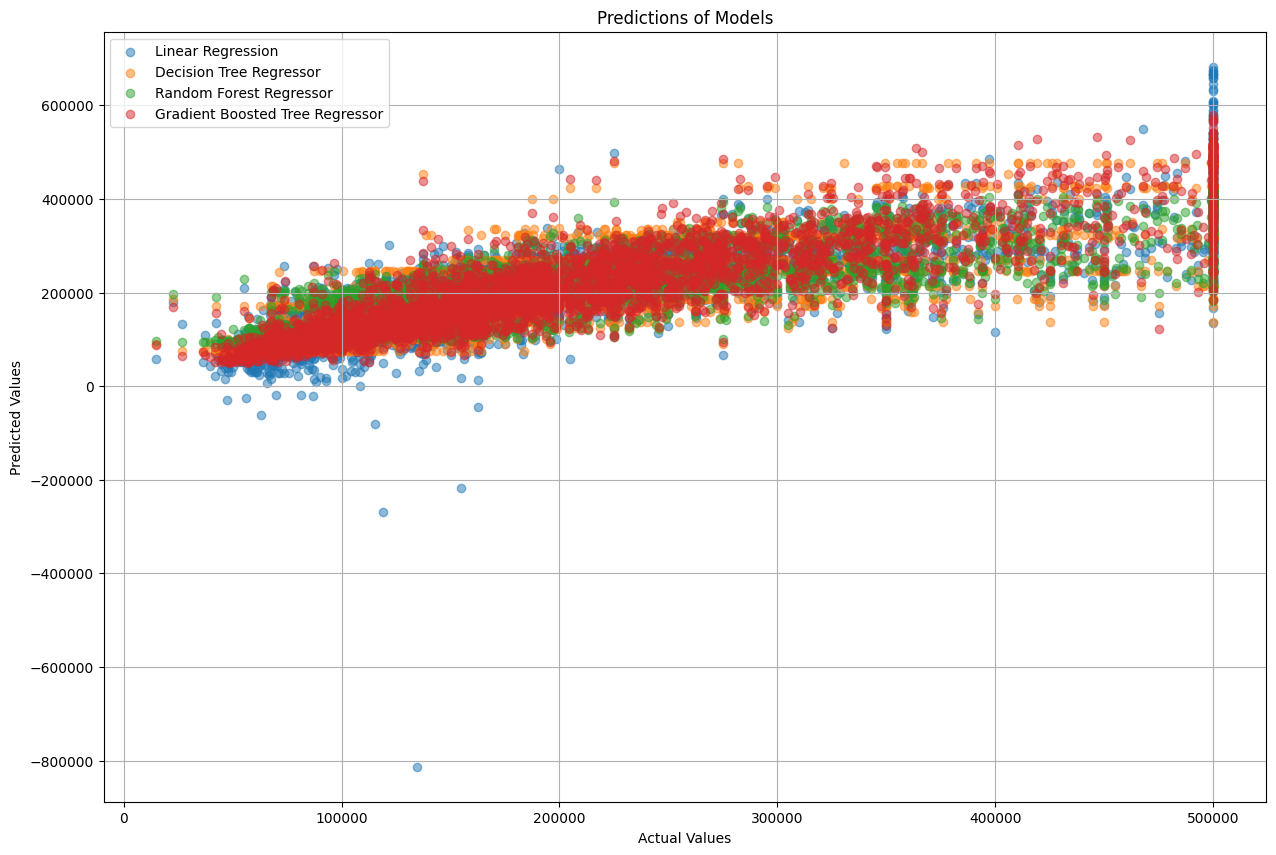

In [14]:
import matplotlib.pyplot as plt

# Separate scatter plots are used for each model.
for model_name, predictions_df in model_predictions.items():
    plt.figure(figsize=(10, 6))
    plt.scatter(predictions_df["median_house_value"], predictions_df["prediction"], alpha=0.5)
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title(f"Predictions of {model_name} Model")
    plt.grid(True)
    plt.show()

# Models are displayed on a single plot.
plt.figure(figsize=(15, 10))
for model_name, predictions_df in model_predictions.items():
    plt.scatter(predictions_df["median_house_value"], predictions_df["prediction"], alpha=0.5, label=model_name)

plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Predictions of Models")
plt.legend()
plt.grid(True)
plt.show()

In [15]:
# Closed SparkSession
spark.stop()